# MAF simple metric example #

## Create the survey footprint plot (nvisits over the sky) ## 

This notebook sets up a relatively simple metric to just count the number of visits at each point in the sky.
This introduces the basic concepts of `rubin_sim.maf.metrics`, `rubin_sim.maf.slicers`, and a `rubin_sim.maf.MetricBundle`, as well as how to combine these and generate the output desired - a map of the number of visits per pointing over the sky. 

For a more in-depth better sequenced introduction to MAF, please look through the [tutorials](https://github.com/lsst/rubin_sim_notebooks/tree/main/maf/tutorial#readme). This notebook gives you another example of this in action.

In [1]:
# import useful packages 

import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import rubin_sims maf packages 

import rubin_sim.maf as maf
from rubin_sim.data import get_baseline

In MAF, it is useful to think of the 'thing we want to evaluate' in three pieces:
 * are there a subset of visits to consider (r band only?) -- this maps to the MAF "constraint"
 * over what value should it be evaluated (the sky? the airmass values?) -- this maps to the MAF "slicer"
 * what are we calculating per <value> (number of visits per point on the sky?) -- this maps to the MAF "metric"

The MAF 'constraint' is fairly simple, in that it is a sql constraint used to subselect particular visits from the opsim output database.

The MAF 'slicer' is often straightforward, as for most science the appropriate answer is "I want to evaluate X over the entire sky"  -- and so the choice is often the HealpixSlicer, and the next question is just 'what resolution is useful' (unless your metric is complicated, nside=64 is fine). 

The MAF 'metric' can be the trickiest part. For simple evaluations - like the number of visits per pointing - there are stock metrics that are likely to be useful. For more complex, higher-level science, you may need to write your own metric.  

As an introduction however, we will just calculate the number of visits per pointing over the entire sky, for one of our baseline runs.

In [4]:
opsdb = get_baseline()
opsim = os.path.basename(opsdb).replace('.db','')
print(opsim)

baseline_v3.3_10yrs


In [5]:
metric = maf.metrics.CountMetric(col='observationStartMJD', metric_name='Nvisits')
nside = 64
slicer = maf.slicers.HealpixSlicer(nside=nside)
constraint = None

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


These are then combined into a MetricBundle - this specifies exactly what, how and on what data you want to measure something. 
You can also add some metadata information that will get stored with the metricbundle (this is useful!). A great thing to include is the opsim run name.

In [6]:
bundle = maf.MetricBundle(metric, slicer, constraint, run_name=opsim)

And now we can pass those all together into the object which will actually run the calculation of the metric(s) for us. The output which is stored on disk will be stored in `outDir` -- the default (if not specified) is simply the current directory.

In [7]:
outDir = 'temp_nvisits'
g = maf.MetricBundleGroup({'nvisits': bundle}, opsdb, out_dir=outDir)

In [8]:
# Calculate the metrics
g.run_all()

Note that now our metric bundle has a new attribute - `metric_values` - which holds the calculated metric data (it's a numpy masked array). We can have a look at that, calculate additional summary statistics, and generate plots.

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 1213 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

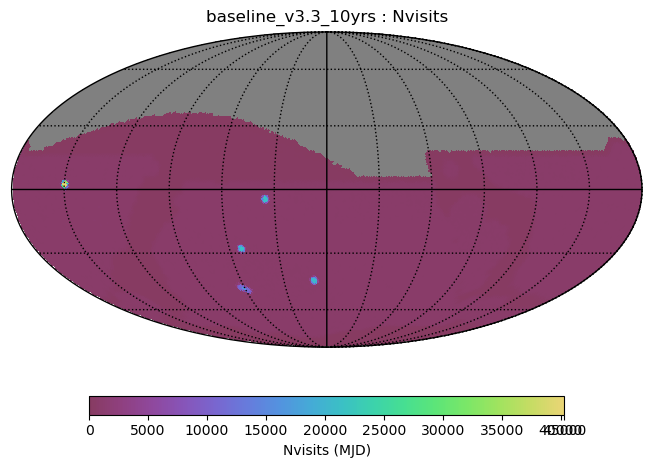

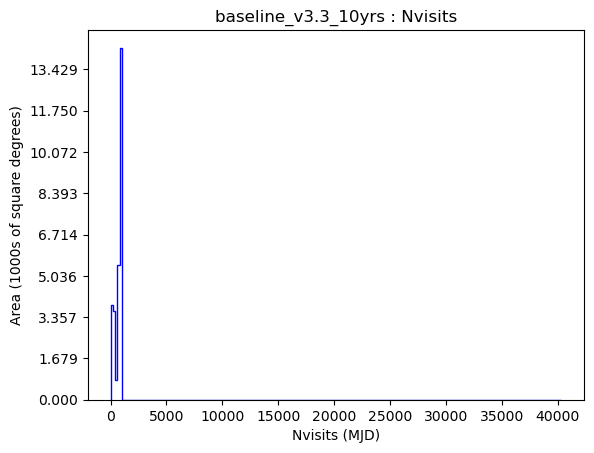

In [9]:
bundle.plot()

That plot isn't super helpful, because the scale is set by just the min/max data .. which corresponds to the deep drilling fields. So we can change those plot limits by setting the "plotDict" attribute for the bundle.

/Users/lynnej/lsst_repos/rubin_sim/rubin_sim/maf/utils/maf_utils.py:143: UserWarning: Optimal bin calculation tried to make 1213 bins, returning 200
  warnings.warn(


{'SkyMap': 1, 'Histogram': 2}

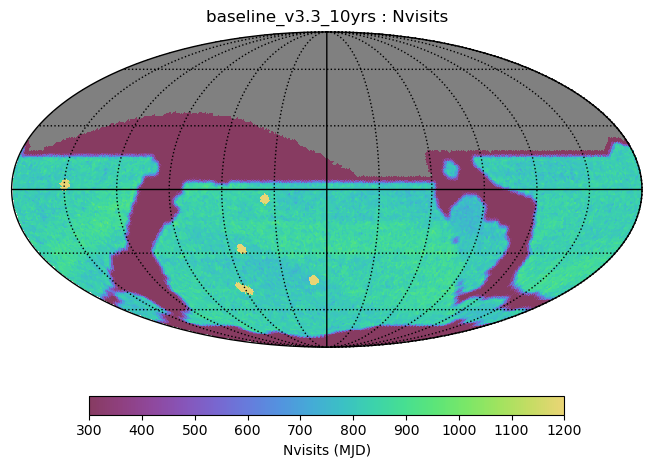

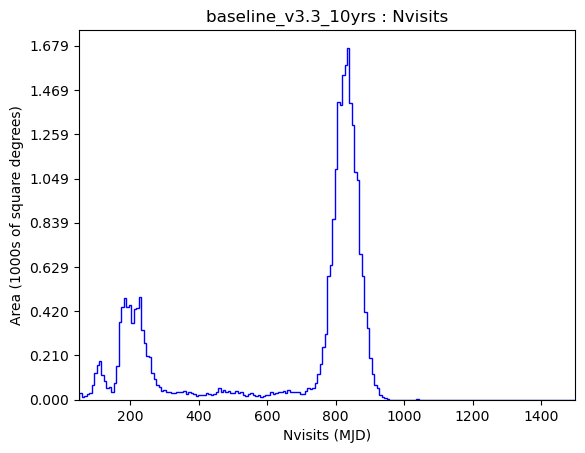

In [10]:
plot_dict = {'color_min': 300, 'color_max': 1200, 'x_min':50, 'x_max':1500}
bundle.set_plot_dict(plot_dict)
bundle.plot()

I needed to do some fancier things with the plot, including labelling different regions. This isn't a necessary thing to do with your output plots, but in case it's useful, here's an example.

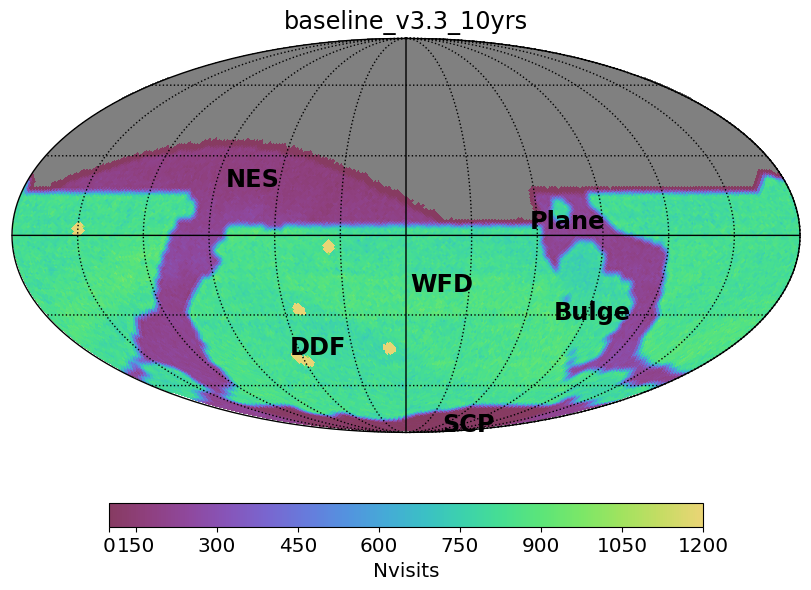

In [12]:
# I needed a copy of the skymaps with regions labelled.
figformat = 'png'
ph = maf.PlotHandler(savefig=False, fig_format=figformat, thumbnail=False, dpi=270, out_dir=outDir)
ph.set_metric_bundles([bundle])
ph.plot(plot_func=maf.plots.HealpixSkyMap(),
        plot_dicts={'color_min': 100, 'color_max':1200, 'figsize': (8, 7),  'nTicks': 7,
                   'labelsize': 'x-large', 'fontsize':'x-large', 'xlabel': "Nvisits"})
plt.figtext(0.51, 0.45, r'WFD', fontsize='xx-large', fontweight='bold')
plt.figtext(0.28, 0.6, r'NES', fontsize='xx-large', fontweight='bold')
plt.figtext(0.69, 0.41, r'Bulge', fontsize='xx-large', fontweight='bold')
plt.figtext(0.66, 0.54, r'Plane', fontsize='xx-large', fontweight='bold')
plt.figtext(0.55, 0.25, r'SCP', fontsize='xx-large', fontweight='bold')
plt.figtext(0.36, 0.36, r'DDF', fontsize='xx-large', fontweight='bold')
plt.title(f'{opsim}', fontsize='xx-large', fontweight='normal')
# We have to save the figure separately, because otherwise labels aren't getting saved.
plt.savefig(os.path.join(outDir, f'{opsim}_nvisits.{figformat}' ), 
            facecolor='w', edgecolor='w', bbox_inches='tight',dpi=270, format=figformat)

In [33]:
# What is the total area of the footprint? 
import healpy as hp
pix2area = hp.nside2pixarea(nside, degrees=True)

print("                  ", "npix   ", "sq deg")
print("all healpix points",  len(bundle.metric_values), f"{len(bundle.metric_values)*pix2area :.0f}")
      
for nvis in [10, 10000]:
    npix = len(np.where(bundle.metric_values > nvis)[0])
    print(f"points above {nvis}",  npix, f"{npix*pix2area: .0f}")

# NOTE I didn't calculate area above 750 visits per pointing because each visit here counts as 1 .. no matter exposure time.
# the fO_Area metric uses the CountExpLim metric, which accounts for shorter exposure times and longer .. so each 'visit' is 30s equivalent
# thus the answer here would not agree with fOArea metric results, which could be confusing.

                   npix    sq deg
all healpix points 49152 41253
points above 10 39873  33465
points above 10000 6529  5480
